### Package Imports

In [1]:
#Package imports
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import utils
sns.set_style('darkgrid')
import pandas_datareader as web #Package for pulling data from the web
from datetime import date
import prophet
import yfinance as yf

### Pulling in Data

In [2]:
#Pulling in the tickers and economic predicators we're interested in
#ONLN = Online Retail ETF, FTXD = Nasdaq Retail ETF, XLY = S&P Consumer Discretionary ETF, 
#IYW= iShares US Tech ETF, AMZN = Amazon, EBAY = Ebay, FB = Facebook
#JETS = Global Airline ETF (Recovery trade), XOP = S&P O&G Exploration and Production ETF (Recovery Trade)
#GOVT = US T-Bond ETF, CL=F = Crude, GC=F = Gold, SI=F = Silver, HG=F = Copper, ^VIX = CBOE Vix
tickers = ['ETSY','SPY','ONLN','FTXD','XLY','IHE','AMZN','EBAY','FB',
           'JETS','XOP','GOVT','CL=F','GC=F','SI=F','HG=F','^VIX']

#Getting the most up to date data we can
today = date.today() #This function automatically updates with today's data

data = yf.download(tickers, start = '2020-06-01', end = today, auto_adjust=True)
etf_df = data['Close']

#Dropping missing vals
etf_df = etf_df.dropna()

#Checking the 5 most recent values
etf_df.head(5)

[*********************100%***********************]  17 of 17 completed


,AMZN,CL=F,EBAY,ETSY,FB,FTXD,GC=F,GOVT,HG=F,IHE,JETS,ONLN,SI=F,SPY,XLY,XOP,^VIX
Date,,,,,,,,,,,,,,,,,
2020-06-01,2471.040039,35.439999,44.648911,78.589996,231.910004,22.778193,1737.800049,27.383593,2.4745,153.412994,15.663684,47.061333,18.768000,299.746704,124.199928,51.980247,28.230000
2020-06-02,2472.409912,36.810001,45.419399,81.860001,232.720001,23.216288,1725.199951,27.334558,2.4945,155.054886,16.003548,47.979267,18.207001,302.228638,125.259941,53.791130,26.840000
2020-06-03,2478.399902,37.290001,45.883671,80.660004,230.160004,23.545359,1697.800049,27.226665,2.4965,155.418671,17.173077,48.364208,17.921000,306.250763,127.627632,54.842617,25.660000
2020-06-04,2460.600098,37.410000,48.758190,80.300003,226.289993,23.467056,1718.900024,27.128588,2.4930,153.717789,19.162273,48.216148,18.024000,305.446381,126.983696,55.494923,25.809999
2020-06-05,2483.000000,39.549999,48.224773,78.720001,230.770004,24.055815,1676.199951,27.040316,2.5570,154.720596,20.081903,48.620831,17.443001,313.274750,130.025040,62.037483,24.520000


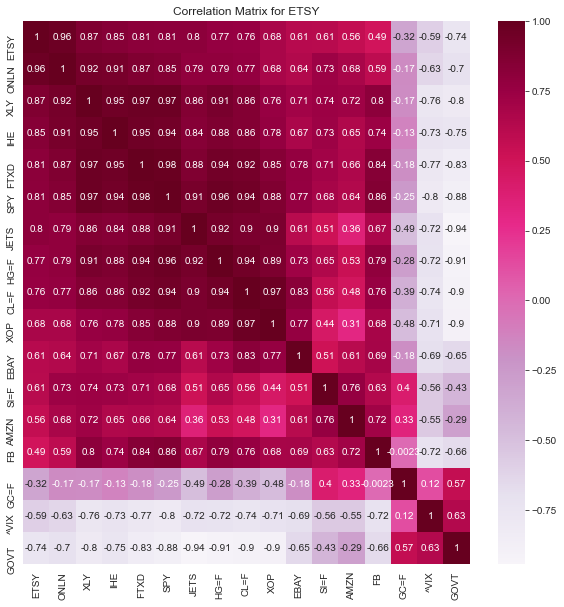

In [3]:
# Set target company
target=['ETSY']
#Creating correlation matrix
corr_mat = etf_df.corr()
fig, ax = plt.subplots(figsize = (10,10))
# sns.heatmap(corr_mat)

#Quantifying the Correlation Matrix
i = len(tickers)
columns = corr_mat.nlargest(i,'ETSY')['ETSY'].index
corrmat = np.corrcoef(etf_df[columns].values.T)
heatmap = sns.heatmap(corrmat,
            cbar=True,
            annot=True,
            cmap='PuRd',
            xticklabels = columns.values,
            yticklabels = columns.values)
ax.set_title('Correlation Matrix for ETSY')
plt.show()

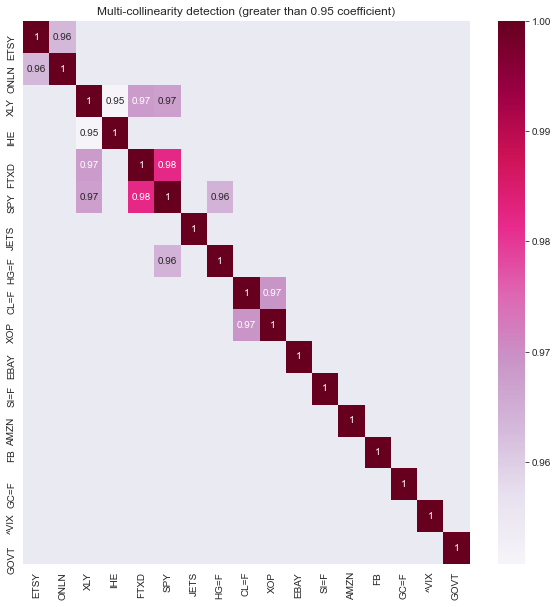

In [4]:
fig, ax = plt.subplots(figsize = (10,10))


#Quantifying the Correlation Matrix
i = len(tickers)
#select Multicollinearity threshold
thr=.95


columns = corr_mat.nlargest(i,'ETSY')['ETSY'].index
corrmat = np.corrcoef(etf_df[columns].values.T)
heatmap = sns.heatmap(corrmat,
            cbar=True,
            annot=True,
            mask=corrmat < thr,
            cmap='PuRd',
            xticklabels = columns.values,
            yticklabels = columns.values)
ax.set_title(f'Multi-collinearity detection (greater than {thr} coefficient)')
plt.show()

In [5]:
#removing target from collinearity check
corr_mat = corr_mat.drop(target, axis=1)
corr_mat = corr_mat.drop(target, axis=0)
corr_mat

,AMZN,CL=F,EBAY,FB,FTXD,GC=F,GOVT,HG=F,IHE,JETS,ONLN,SI=F,SPY,XLY,XOP,^VIX
AMZN,1.000000,0.483198,0.609911,0.715905,0.657011,0.332582,-0.291960,0.532202,0.645251,0.360923,0.675713,0.764768,0.638450,0.720959,0.307630,-0.553245
CL=F,0.483198,1.000000,0.825316,0.758947,0.918346,-0.390602,-0.899909,0.942672,0.856736,0.899132,0.774120,0.560518,0.942283,0.858445,0.969047,-0.742020
EBAY,0.609911,0.825316,1.000000,0.690978,0.778440,-0.180716,-0.650636,0.726279,0.666528,0.612545,0.642041,0.509710,0.766497,0.706954,0.770116,-0.690376
FB,0.715905,0.758947,0.690978,1.000000,0.842601,-0.002340,-0.656443,0.787678,0.737072,0.671434,0.587615,0.630724,0.855719,0.804540,0.681484,-0.716247
FTXD,0.657011,0.918346,0.778440,0.842601,1.000000,-0.181228,-0.834671,0.938815,0.949332,0.876198,0.871425,0.707925,0.982063,0.967878,0.845618,-0.770614
GC=F,0.332582,-0.390602,-0.180716,-0.002340,-0.181228,1.000000,0.565094,-0.279619,-0.130653,-0.485594,-0.166907,0.402036,-0.246375,-0.173447,-0.478112,0.122269
GOVT,-0.291960,-0.899909,-0.650636,-0.656443,-0.834671,0.565094,1.000000,-0.906807,-0.754322,-0.944257,-0.699808,-0.430488,-0.875183,-0.804100,-0.896031,0.628410
HG=F,0.532202,0.942672,0.726279,0.787678,0.938815,-0.279619,-0.906807,1.000000,0.882885,0.923122,0.793294,0.646400,0.964025,0.905466,0.888283,-0.721042
IHE,0.645251,0.856736,0.666528,0.737072,0.949332,-0.130653,-0.754322,0.882885,1.000000,0.840520,0.911740,0.727883,0.937618,0.950732,0.779541,-0.726635
JETS,0.360923,0.899132,0.612545,0.671434,0.876198,-0.485594,-0.944257,0.923122,0.840520,1.000000,0.788722,0.514129,0.914519,0.862515,0.897070,-0.715243


In [6]:
# removing multicollinearity
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
# print(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > thr)]
print(to_drop)
etf_df1 = etf_df.drop(to_drop, axis=1)
etf_df1.head()

['SPY', 'XLY', 'XOP']


,AMZN,CL=F,EBAY,ETSY,FB,FTXD,GC=F,GOVT,HG=F,IHE,JETS,ONLN,SI=F,^VIX
Date,,,,,,,,,,,,,,
2020-06-01,2471.040039,35.439999,44.648911,78.589996,231.910004,22.778193,1737.800049,27.383593,2.4745,153.412994,15.663684,47.061333,18.768000,28.230000
2020-06-02,2472.409912,36.810001,45.419399,81.860001,232.720001,23.216288,1725.199951,27.334558,2.4945,155.054886,16.003548,47.979267,18.207001,26.840000
2020-06-03,2478.399902,37.290001,45.883671,80.660004,230.160004,23.545359,1697.800049,27.226665,2.4965,155.418671,17.173077,48.364208,17.921000,25.660000
2020-06-04,2460.600098,37.410000,48.758190,80.300003,226.289993,23.467056,1718.900024,27.128588,2.4930,153.717789,19.162273,48.216148,18.024000,25.809999
2020-06-05,2483.000000,39.549999,48.224773,78.720001,230.770004,24.055815,1676.199951,27.040316,2.5570,154.720596,20.081903,48.620831,17.443001,24.520000


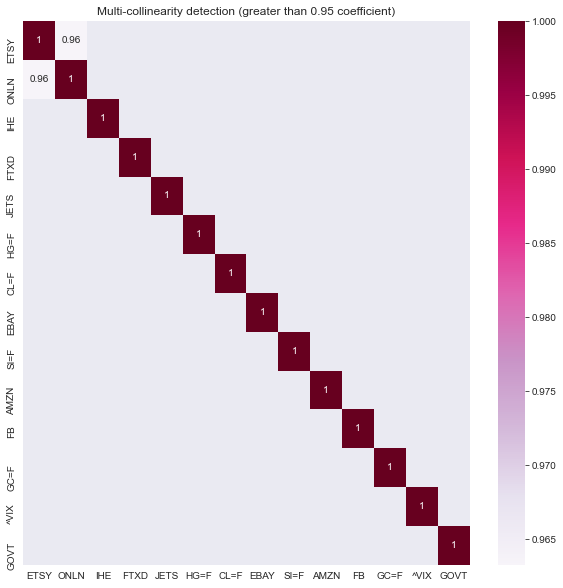

In [7]:
#checking again for multicollinearity
fig, ax = plt.subplots(figsize = (10,10))
corr_mat = etf_df1.corr()

#Quantifying the Correlation Matrix
i = len(tickers)
columns = corr_mat.nlargest(i,'ETSY')['ETSY'].index
corrmat = np.corrcoef(etf_df[columns].values.T)
heatmap = sns.heatmap(corrmat,
            cbar=True,
            annot=True,
            mask=corrmat < thr,
            cmap='PuRd',
            xticklabels = columns.values,
            yticklabels = columns.values)
ax.set_title(f'Multi-collinearity detection (greater than {thr} coefficient)')
plt.show()

### Forecasting Predicator Variables Individually

In [8]:
#Creating dfs to model with
etf_df = etf_df1
#FTXD, IHE, ONLN

#Regressor 1 (FTXD)
reg1_prophet = pd.DataFrame()
reg1_prophet['ds'] = etf_df.index
reg1_prophet['y'] = etf_df['FTXD'].values

#Regressor 2 (ONLN)
reg2_prophet = pd.DataFrame()
reg2_prophet['ds'] = etf_df.index
reg2_prophet['y'] = etf_df['ONLN'].values

#Regressor 3 (IHE)
reg3_prophet = pd.DataFrame()
reg3_prophet['ds'] = etf_df.index
reg3_prophet['y'] = etf_df['IHE'].values

### Fitting Models

In [9]:
#Pred 1
reg1_m = prophet.Prophet()
reg1_m.fit(reg1_prophet)
reg1_future = reg1_m.make_future_dataframe(freq='m', periods=3);

#Pred 2
reg2_m = prophet.Prophet()
reg2_m.fit(reg2_prophet)
reg2_future = reg2_m.make_future_dataframe(freq='m', periods=3);

#Pred 3
reg3_m = prophet.Prophet()
reg3_m.fit(reg3_prophet)
reg3_future = reg3_m.make_future_dataframe(freq='m', periods=3);

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Creating Forecast for Next 6 Months of Predicator Variables

In [10]:
#Defining length of forecast
future_pred_length = reg1_m.make_future_dataframe(freq='m',periods = 3)

#Pred 1
reg1_forecast = reg1_m.predict(future_pred_length)   
reg1_pred = pd.DataFrame(reg1_forecast['trend'].values)

#Pred 2
reg2_forecast = reg2_m.predict(future_pred_length)
reg2_pred = pd.DataFrame(reg2_forecast['trend'].values)

#Pred 3
reg3_forecast = reg3_m.predict(future_pred_length)
reg3_pred = pd.DataFrame(reg3_forecast['trend'].values)

In [11]:
#Combining predicators into one df
frames = [future_pred_length,reg1_pred,reg2_pred,reg3_pred]
predicator_forecast = pd.concat(frames,axis=1)
predicator_forecast.columns = ['ds','Reg_1','Reg_2','Reg_3']
predicator_forecast.head()

,ds,Reg_1,Reg_2,Reg_3
0,2020-06-01,22.770068,47.204441,151.162527
1,2020-06-02,22.807083,47.410112,151.238557
2,2020-06-03,22.844098,47.615784,151.314587
3,2020-06-04,22.881113,47.821455,151.390617
4,2020-06-05,22.918128,48.027126,151.466646


### Forecasting ETF Performance with Predicator Variables

In [12]:
#Creating dfs to train model with (FB Prophet format)
etf_prophet = pd.DataFrame()
etf_prophet['ds'] = etf_df.index
etf_prophet['y'] = etf_df['ETSY'].values
etf_prophet['Reg_1'] = etf_df['FTXD'].values
etf_prophet['Reg_2'] = etf_df['ONLN'].values
etf_prophet['Reg_3'] = etf_df['IHE'].values

In [13]:
#Checking Prophet df
etf_prophet.head()

,ds,y,Reg_1,Reg_2,Reg_3
0,2020-06-01,78.589996,22.778193,47.061333,153.412994
1,2020-06-02,81.860001,23.216288,47.979267,155.054886
2,2020-06-03,80.660004,23.545359,48.364208,155.418671
3,2020-06-04,80.300003,23.467056,48.216148,153.717789
4,2020-06-05,78.720001,24.055815,48.620831,154.720596


In [14]:
#Defining model, adding additional regressors and fitting model
m = prophet.Prophet()
#m.add_regressor('Reg_1')
m.add_regressor('Reg_2')
m.add_regressor('Reg_3')
m.fit(etf_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
#Forecasting the next 90 days
etf_forecast = m.predict(predicator_forecast) 
etf_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Reg_2,Reg_2_lower,Reg_2_upper,Reg_3,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
269,2021-07-01,143.434221,155.878436,175.533339,143.434221,143.434221,23.742162,23.742162,23.742162,-14.001166,...,9.740997,9.740997,9.740997,12.430291,12.430291,12.430291,0.0,0.0,0.0,165.605509
270,2021-07-02,143.185186,156.464447,176.488573,143.185186,143.185186,23.665835,23.665835,23.665835,-14.110500,...,9.555335,9.555335,9.555335,13.249544,13.249544,13.249544,0.0,0.0,0.0,165.990065
271,2021-07-31,135.963162,98.501046,118.603679,135.163959,137.086211,21.452344,21.452344,21.452344,-17.281206,...,4.171138,4.171138,4.171138,-31.988189,-31.988189,-31.988189,0.0,0.0,0.0,108.146111
272,2021-08-31,128.243067,129.038488,151.001187,125.545699,131.778795,19.086198,19.086198,19.086198,-20.670581,...,-1.584383,-1.584383,-1.584383,13.295974,13.295974,13.295974,0.0,0.0,0.0,139.954658
273,2021-09-30,120.772008,114.424153,138.438474,114.978431,127.161985,16.796379,16.796379,16.796379,-23.950621,...,-7.154242,-7.154242,-7.154242,12.430291,12.430291,12.430291,0.0,0.0,0.0,126.048057


Text(0.5, 1.0, '3 Month ETSY Forecast [ETSY]')

<Figure size 1440x720 with 0 Axes>

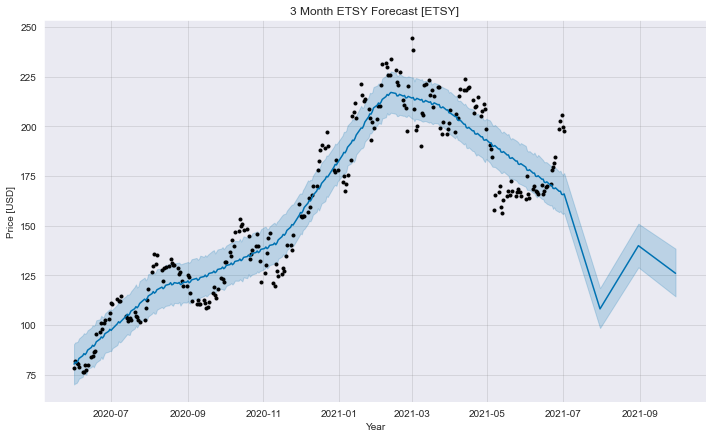

In [16]:
#Visualizing forecast
plt.figure(figsize = (20,10))
m.plot(etf_forecast, xlabel='Year',ylabel ='Price [USD]');
plt.title('3 Month ETSY Forecast [ETSY]')

<Figure size 1440x720 with 0 Axes>

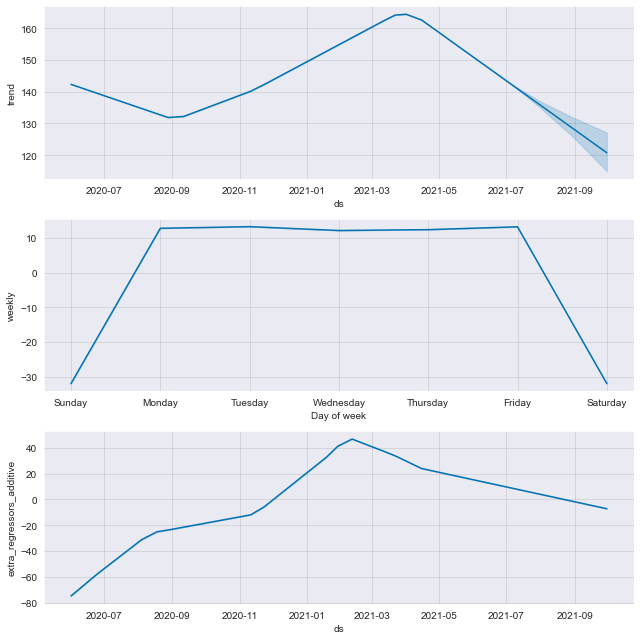

In [17]:
#Plotting forecast components
plt.figure(figsize = (20,10))
m.plot_components(etf_forecast);